## Getting started on synthetic datasets

In [1]:
# import ggml and remaining packages

import ggml_ot
import numpy as np
import seaborn as sns
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

/home/kuebra/.cache/pypoetry/virtualenvs/ggml-ot-qpshuKxx-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# define parameters
alpha = 10
lambda_ = 0.1

neighbor_t = 5
rank_k = 5 

lr = 0.02
norm = 1

#Number of element sampled 
n = 100

#Length of list defines number of classes
means = [5,10,15]
label =[0,1,2]

#Length of list defines number of distributions in each class
offsets = np.arange(0,30,3)+1.5

#Length of list defines number of modes that can not be differentiated between classes
shared_means_x = [0, 40]
shared_means_y = [0, 50]

noise_scale = 1
noise_dims = 199

In [3]:
# create a synthetic dataset with defined paramters
data = ggml_ot.synthetic_Dataset(distribution_size=n, class_means = means, offsets = offsets, shared_means_x=shared_means_x, shared_means_y=shared_means_y, plot=False, varying_size=False,t=neighbor_t,noise_scale=noise_scale,noise_dims=noise_dims)

passed neighs: 5


In [4]:
# create training dataset that contains the dataset and meta data like the batching information
training_dataset = DataLoader(data, batch_size=128, shuffle=True)

Running GGML with alpha: 10, lambda: 0.1, rank: 5


100%|██████████| 12/12 [02:32<00:00, 12.72s/it]


Iteration 1 with Loss  149.53048706054688


100%|██████████| 12/12 [02:27<00:00, 12.29s/it]


Iteration 2 with Loss  116.85204315185547


100%|██████████| 12/12 [02:24<00:00, 12.05s/it]


Iteration 3 with Loss  104.07807922363281


100%|██████████| 12/12 [02:25<00:00, 12.15s/it]


Iteration 4 with Loss  104.18812561035156


100%|██████████| 12/12 [01:39<00:00,  8.26s/it]


Iteration 5 with Loss  83.94170379638672
Compute all OT distances after 5 iterations


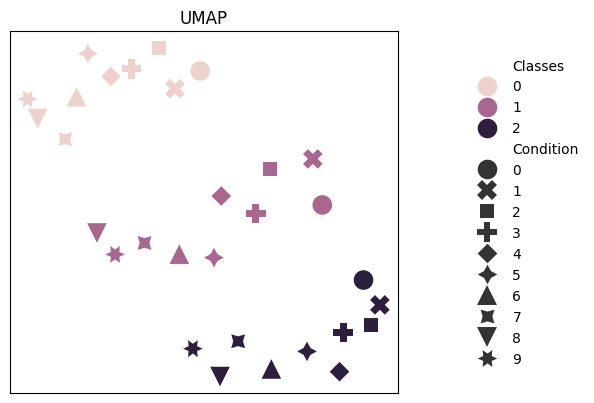

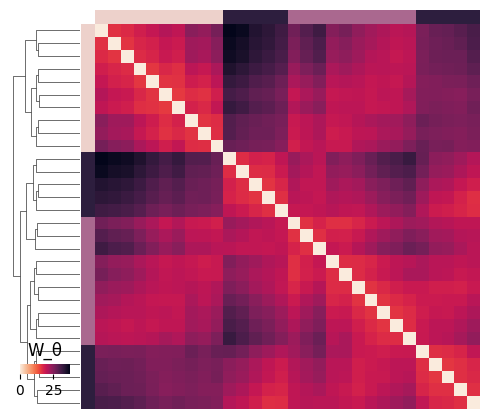

In [5]:
# train the model
# --> learns the global ground metric on the given dataset
w_theta = ggml_ot.ggml(training_dataset,a=alpha,l=lambda_,k=rank_k,lr=lr,norm=norm,max_iterations=5,plot_i_iterations=5,dataset=data,n_threads=64)

## Plotting functions

### Plotting the distributions:

- mandatory inputs: 
  - a list of distributions
  - corresponding labels
- optional inputs:
  - projection: function to apply to the distributions before plotting if desired
  - title: title of the plot
  - legend: whether a legend should be added

PCA
(30, 300, 200)


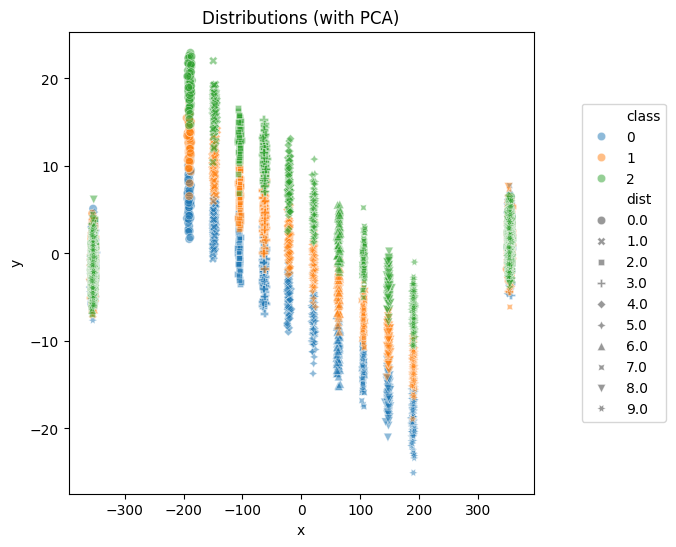

In [6]:
# plot distributions using PCA
a = data.distributions
b = data.distributions_labels
ggml_ot.plot_distribution(a, b, title = "Distributions (with PCA)", legend = True)
plt.show()

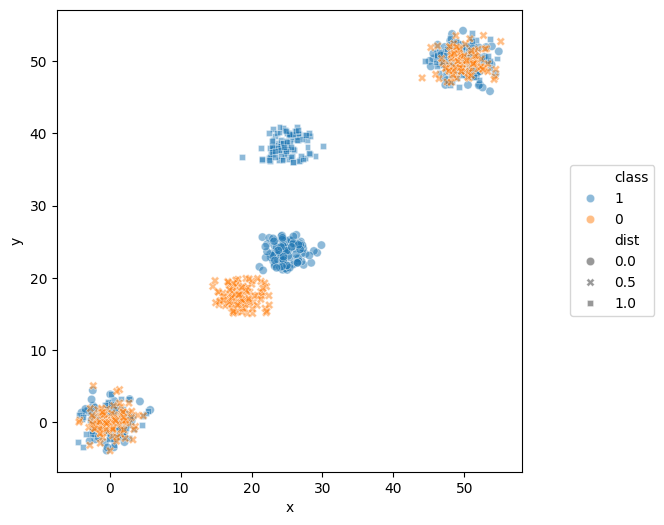

In [7]:
train_features, train_labels = next(iter(training_dataset))
trpl_distributions = train_features[0]
trpl_label = train_labels[0]
ggml_ot.plot_distribution(trpl_distributions[:,:,:2],np.asarray(trpl_label,dtype=int))

plt.show()

### Plotting the ellipses to covariance matrices
- mandatory inputs:
  - a list of covariance matrices
- optional inputs:
  - ax: ax object on which to plot the ellipses
  - title: title of the plot

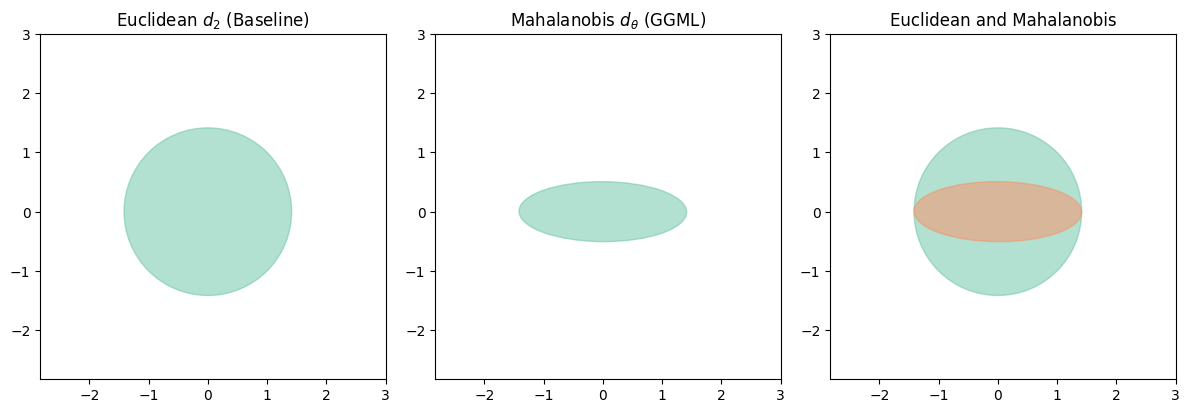

In [8]:
np.set_printoptions(suppress=True,precision=16)

fig, axs = plt.subplots(ncols=3, figsize=(12, 6))

# plot no.1: Euclidean distance (identity matrix as covariance)
ax = ggml_ot.plot_ellipses(np.identity(2), ax=axs[0])
ax.set_title(r'Euclidean $d_2$ (Baseline)')

# plot no.2: Mahalanobis distance (based on w_theta)
m = np.transpose(w_theta) @ w_theta  # Mahalanobis matrix
ax = ggml_ot.plot_ellipses(m[:2, :2], ax=axs[1])
ax.set_title(r'Mahalanobis $d_\theta$ (GGML)')

# plot no.3: Euclidean and Mahalanobis distances
ax = ggml_ot.plot_ellipses([np.identity(2), m[:2, :2]], ax=axs[2])
ax.set_title(r'Euclidean and Mahalanobis')

plt.tight_layout()
plt.show()

### Plotting data as color-encoded matrix (heatmap)
- mandatory inputs:
  - data to plot
- optional inputs:
  - labels: labels of the data
  - xlabels: labels for x axis
  - ylabels: labels for y axis
  - ax: axes object on which to plot the heatmap
  - title: title of the plot

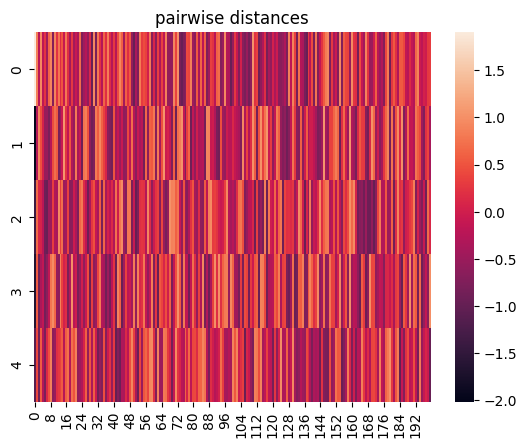

In [9]:
ggml_ot.plot_heatmap(w_theta)

In [10]:
# get the optimal transport distances using w_theta
D_ggml = data.compute_OT_on_dists(w = w_theta, plot = False)

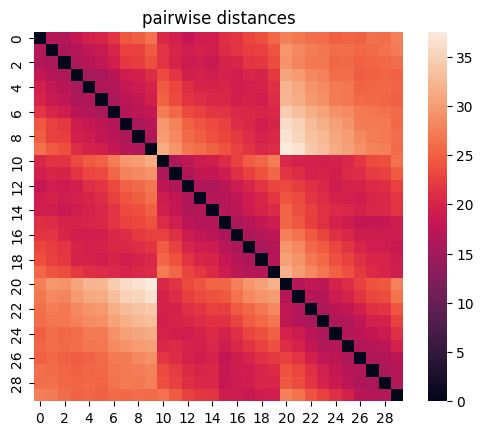

In [11]:
ggml_ot.plot_heatmap(D_ggml)

### Plotting embeddings of distance matrices
- mandatory inputs:
  - distance matrix
- optional inputs:
  - method: dimensionality reduction method
  - precomputed embedding: embedding to plot instead of embedding of distance matrix
  - colors: class labels to use for coloring the points
  - symbols: labels to use for marker styles
  - ax: axes on which to draw the embedding
  - Cluster_ID: indication whether a point is a centroid/ medoid/ representative point of a cluster that is displayed larger
  - title: title of the plot
  - cmap: colormap to use for coloring the points
  - save_path: path to save the plot
  - verbose: whether to display title of plot
  - legend: where to place the legend
  - s: marker size
  - hue_order: order in which class labels should be displayed in legend
  - annotation: text to display on each point
  - linewidth: linewidth of marker edges
  - annotation_image_path: image paths to overlay on plot


/mnt/c/Studium/work/neuer Hiwi Job/ggml-ot/src/ggml_ot/plot/plotting.py:273: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax = sns.scatterplot(df_embed, x='x',y='y',edgecolor="white",alpha=1.0,s=s,linewidth=linewidth,


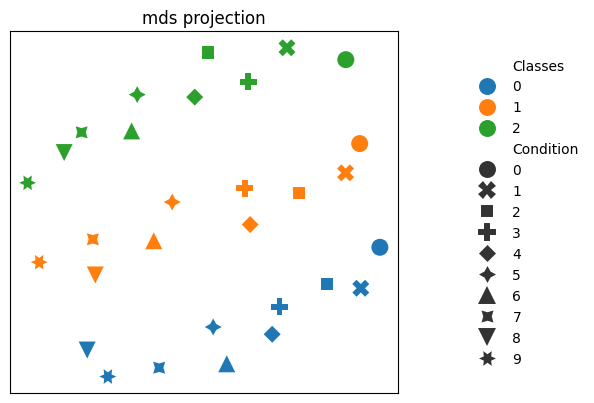

In [12]:
symbols = [i % 10 for i in range(len(data.distributions))]
colors = data.distributions_labels

emb = ggml_ot.plot_emb(D_ggml, method = "mds", symbols = symbols, colors = colors, verbose = True, cmap=sns.color_palette("tab10"), s = 150, legend = "Side")

### Plotting a matrix dataset as a hierarchically-clustered heatmap (clustermap)
- mandatory inputs:
  - distance matrix
  - labels
- optional inputs:
  - cluster: whether to apply hierarchical clustering
  - method: linkage method
  - title: title of the clustermap
  - log: whether to apply logarithmic scaling
  - save_path: whether/ where to save the plot to
  - cmap: color palette for class labels
  - hue_order: ordering of class labels
  - annotation: whether to display sample labels


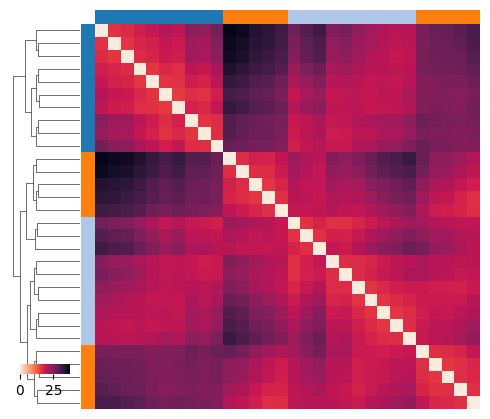

In [13]:
linkage = ggml_ot.plot_clustermap(D_ggml, data.distributions_labels)